In [37]:
# import sys
# import subprocess

# subprocess.check_call([sys.executable, "-m", "pip", "install", "-r", "requirements.txt"])


In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # For pair plots
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score


In [39]:
# Set a random seed for reproducibility
np.random.seed(42)

# Total number of samples
n_samples = 1000

# Number of features per view
n_features_per_view = 8

# Function to generate features for a given class and view
def generate_view(class_label, n_samples, view):
    if view == 1:
        # View 1: Features 0-7
        if class_label == 0:
            # Class 0: Multivariate normal centered at zero
            mean = np.zeros(n_features_per_view)
            cov = np.identity(n_features_per_view)
        else:
            # Class 1: Multivariate normal centered at one
            mean = np.ones(n_features_per_view) * 1.0
            cov = np.identity(n_features_per_view)
        X_view = np.random.multivariate_normal(mean, cov, n_samples)
    elif view == 2:
        # View 2: Features 8-15
        if class_label == 0:
            # Class 0: Multivariate normal centered at one
            mean = np.ones(n_features_per_view) * 1.0
            cov = np.identity(n_features_per_view)
        else:
            # Class 1: Multivariate normal centered at zero
            mean = np.zeros(n_features_per_view)
            cov = np.identity(n_features_per_view)
        X_view = np.random.multivariate_normal(mean, cov, n_samples)
    return X_view


In [40]:
# Number of samples per class
n_samples_per_class = n_samples // 2

# Generate class labels
y = np.array([0] * n_samples_per_class + [1] * n_samples_per_class)

# Shuffle the class labels
np.random.shuffle(y)

# Generate features for both views
X1_list = []
X2_list = []
for class_label in y:
    # Generate features for View 1
    X1_sample = generate_view(class_label, 1, view=1)
    X1_list.append(X1_sample[0])
    # Generate features for View 2
    X2_sample = generate_view(class_label, 1, view=2)
    X2_list.append(X2_sample[0])

# Convert lists to NumPy arrays
X1 = np.array(X1_list)
X2 = np.array(X2_list)


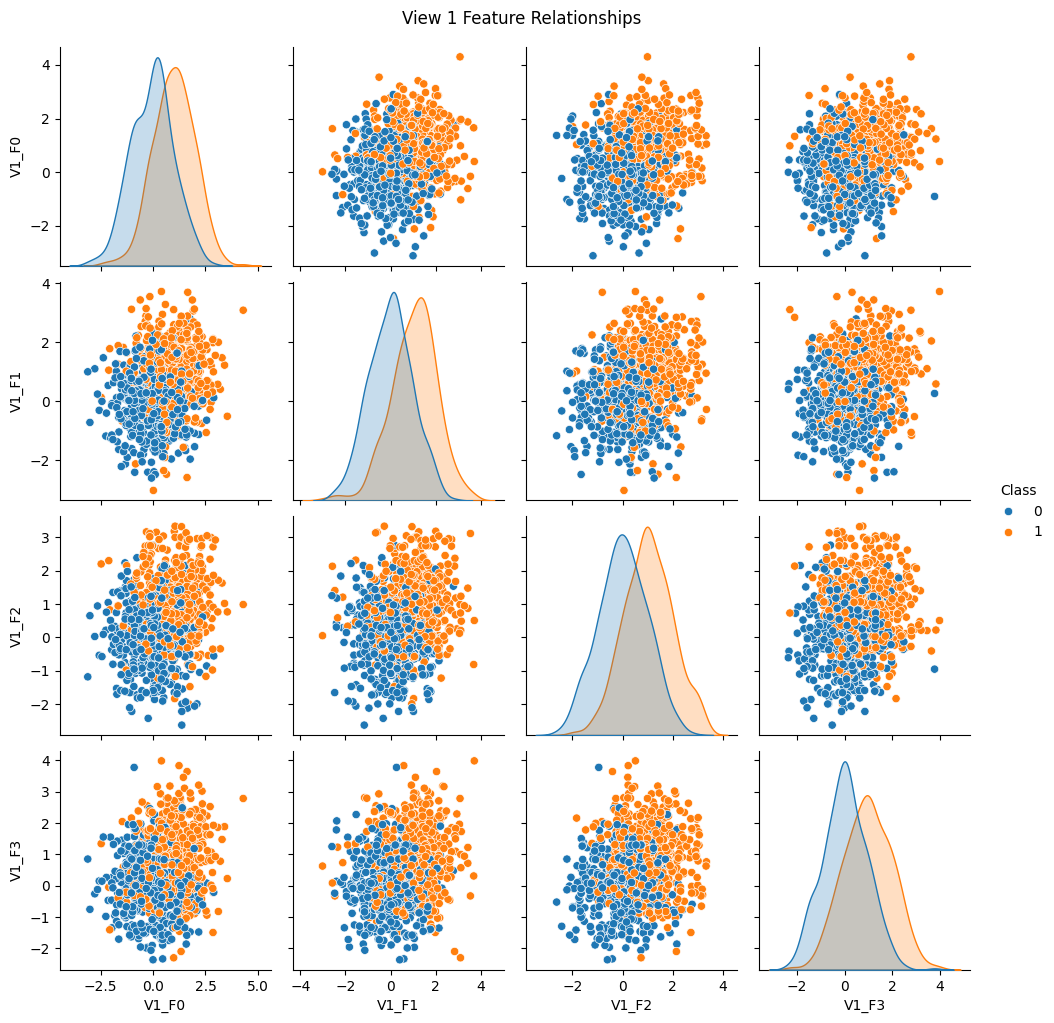

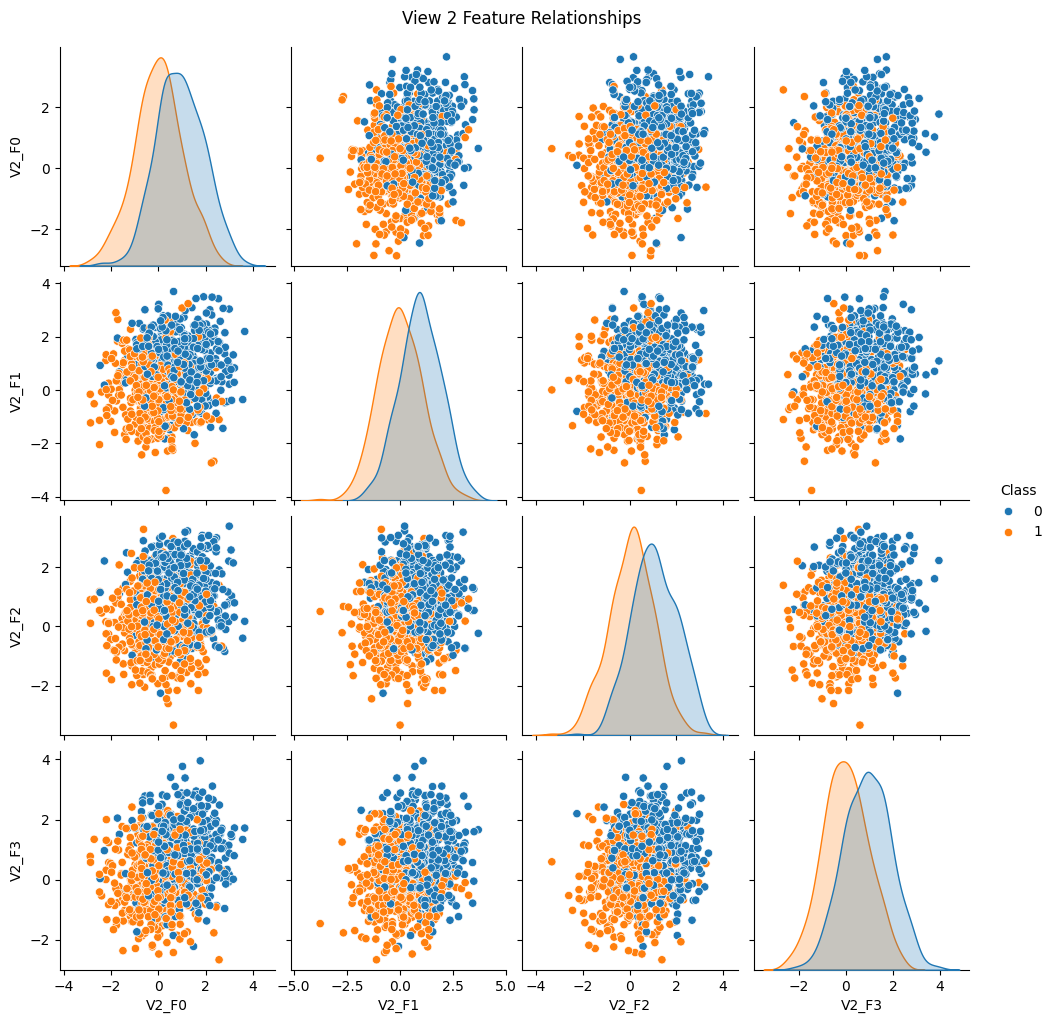

In [41]:
# Select a subset of features to plot (e.g., first 4 features)
features_to_plot = [0, 1, 2, 3]

# Create a DataFrame for View 1
import pandas as pd
df_view1 = pd.DataFrame(X1[:, features_to_plot], columns=[f'V1_F{f}' for f in features_to_plot])
df_view1['Class'] = y

# Pair plot for View 1
sns.pairplot(df_view1, hue='Class', diag_kind='kde')
plt.suptitle('View 1 Feature Relationships', y=1.02)
plt.show()

# Create a DataFrame for View 2
df_view2 = pd.DataFrame(X2[:, features_to_plot], columns=[f'V2_F{f}' for f in features_to_plot])
df_view2['Class'] = y

# Pair plot for View 2
sns.pairplot(df_view2, hue='Class', diag_kind='kde')
plt.suptitle('View 2 Feature Relationships', y=1.02)
plt.show()


In [42]:
# Split into a small labeled set and a large unlabeled set
labeled_ratio = 0.05  # 5% labeled data
unlabeled_ratio = 0.95  # 95% unlabeled data

# Split into labeled and unlabeled data
X1_labeled, X1_unlabeled, X2_labeled, X2_unlabeled, y_labeled, y_unlabeled = train_test_split(
    X1, X2, y, test_size=unlabeled_ratio, stratify=y, random_state=42
)

# Further split the unlabeled data into validation and unlabeled pools
X1_unlabeled, X1_val, X2_unlabeled, X2_val, y_unlabeled_unused, y_val = train_test_split(
    X1_unlabeled, X2_unlabeled, y_unlabeled, test_size=0.2, stratify=y_unlabeled, random_state=42
)

# Initialize label arrays for each classifier
y1_labeled = y_labeled.copy()  # For Classifier on View 1
y2_labeled = y_labeled.copy()  # For Classifier on View 2


In [43]:
# Initialize classifiers for each view
clf_view1 = GaussianNB()
clf_view2 = GaussianNB()

# Train classifiers on the small labeled dataset
clf_view1.fit(X1_labeled, y1_labeled)
clf_view2.fit(X2_labeled, y2_labeled)

# Evaluate initial performance on the validation set
y_pred_v1 = clf_view1.predict(X1_val)
y_pred_v2 = clf_view2.predict(X2_val)
y_pred_combined = (y_pred_v1 + y_pred_v2) >= 1  # At least one predicts class 1

print("Initial accuracy on validation set:")
print(f"Classifier on View 1: {accuracy_score(y_val, y_pred_v1):.4f}")
print(f"Classifier on View 2: {accuracy_score(y_val, y_pred_v2):.4f}")
print(f"Combined Classifier: {accuracy_score(y_val, y_pred_combined):.4f}")


Initial accuracy on validation set:
Classifier on View 1: 0.9263
Classifier on View 2: 0.8789
Combined Classifier: 0.9000


In [48]:
# Lists to store accuracies for plotting convergence
acc_view1 = []
acc_view2 = []
acc_combined = []

# Parameters for co-training
n_iterations = 20
k = 15
confidence_threshold = 0.95  # Higher threshold due to increased features

def get_high_confidence_predictions(clf, X):
    probs = clf.predict_proba(X)
    max_probs = np.max(probs, axis=1)
    preds = np.argmax(probs, axis=1)
    return preds, max_probs

for iteration in range(n_iterations):
    # Classifier on View 1
    preds_v1, probs_v1 = get_high_confidence_predictions(clf_view1, X1_unlabeled)
    high_conf_idx_v1 = np.where(probs_v1 >= confidence_threshold)[0][:k]

    # Classifier on View 2
    preds_v2, probs_v2 = get_high_confidence_predictions(clf_view2, X2_unlabeled)
    high_conf_idx_v2 = np.where(probs_v2 >= confidence_threshold)[0][:k]

    # Mutual Labeling
    X2_new = X2_unlabeled[high_conf_idx_v1]
    y2_new = preds_v1[high_conf_idx_v1]

    X1_new = X1_unlabeled[high_conf_idx_v2]
    y1_new = preds_v2[high_conf_idx_v2]

    # Update Training Data
    X1_labeled = np.vstack([X1_labeled, X1_new])
    y1_labeled = np.concatenate([y1_labeled, y1_new])

    X2_labeled = np.vstack([X2_labeled, X2_new])
    y2_labeled = np.concatenate([y2_labeled, y2_new])

    # Remove labeled examples from unlabeled sets
    remove_idx = np.union1d(high_conf_idx_v1, high_conf_idx_v2)
    X1_unlabeled = np.delete(X1_unlabeled, remove_idx, axis=0)
    X2_unlabeled = np.delete(X2_unlabeled, remove_idx, axis=0)

    # Retrain Classifiers
    clf_view1.fit(X1_labeled, y1_labeled)
    clf_view2.fit(X2_labeled, y2_labeled)

    # Evaluate on Validation Set
    y_pred_v1 = clf_view1.predict(X1_val)
    y_pred_v2 = clf_view2.predict(X2_val)
    y_pred_combined = (y_pred_v1 + y_pred_v2) >= 1

    acc_v1 = accuracy_score(y_val, y_pred_v1)
    acc_v2 = accuracy_score(y_val, y_pred_v2)
    acc_comb = accuracy_score(y_val, y_pred_combined)

    acc_view1.append(acc_v1)
    acc_view2.append(acc_v2)
    acc_combined.append(acc_comb)

    # Print accuracies at certain iterations
    if (iteration + 1) % 5 == 0 or iteration == 0:
        print(f"\nIteration {iteration + 1}")
        print(f"Classifier on View 1 Accuracy: {acc_v1:.4f}")
        print(f"Classifier on View 2 Accuracy: {acc_v2:.4f}")
        print(f"Combined Classifier Accuracy: {acc_comb:.4f}")

    if len(X1_unlabeled) == 0:
        print("No more unlabeled data available.")
        break



Iteration 1
Classifier on View 1 Accuracy: 0.9474
Classifier on View 2 Accuracy: 0.8947
Combined Classifier Accuracy: 0.9053

Iteration 5
Classifier on View 1 Accuracy: 0.9474
Classifier on View 2 Accuracy: 0.8947
Combined Classifier Accuracy: 0.9053

Iteration 10
Classifier on View 1 Accuracy: 0.9474
Classifier on View 2 Accuracy: 0.8947
Combined Classifier Accuracy: 0.9053

Iteration 15
Classifier on View 1 Accuracy: 0.9474
Classifier on View 2 Accuracy: 0.8947
Combined Classifier Accuracy: 0.9053

Iteration 20
Classifier on View 1 Accuracy: 0.9474
Classifier on View 2 Accuracy: 0.8947
Combined Classifier Accuracy: 0.9053


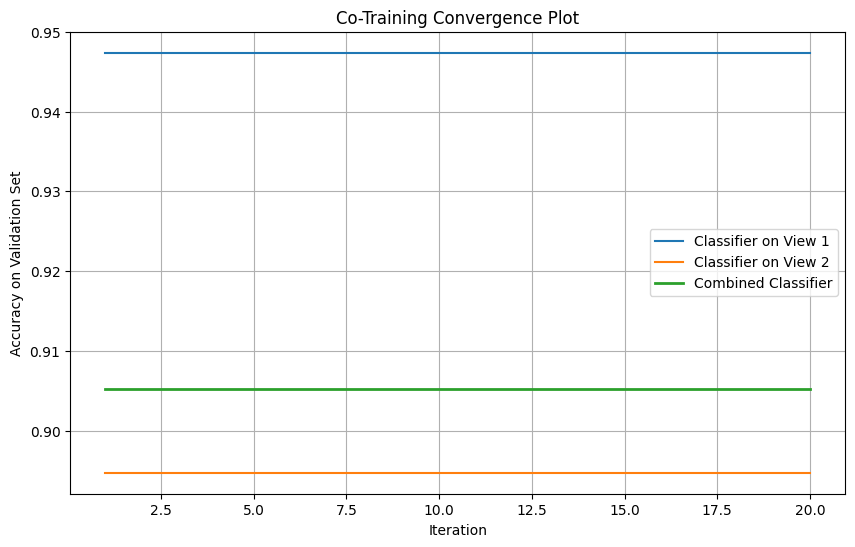

In [49]:
# Plotting the Convergence of Accuracies
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(acc_view1) + 1), acc_view1, label='Classifier on View 1')
plt.plot(range(1, len(acc_view2) + 1), acc_view2, label='Classifier on View 2')
plt.plot(range(1, len(acc_combined) + 1), acc_combined, label='Combined Classifier', linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Accuracy on Validation Set')
plt.title('Co-Training Convergence Plot')
plt.legend()
plt.grid(True)
plt.show()
